# EDA and cleaning for raw analysts rating

## importing libraries

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer

## loading the data

In [2]:
try:
   # Attempt to read the CSV file
   df= pd.read_csv(r"C:\Users\tsion\OneDrive\Desktop\sentiment_analysis_price_pridiction_week1\data\raw_analyst_ratings.csv")
except FileNotFoundError:
   # Handle the case where the file does not exist
   print("The specified file was not found. Please check the file path.")
   
except pd.errors.EmptyDataError:
    # Handle the case where the file is empty
    print("The file is empty. Please provide a valid CSV file with data.")
print("CSV file loaded successfully.")

CSV file loaded successfully.


## Data profileing

In [3]:
# Basic info
print("head", df.head())
print("Dataset Shape:", df.shape)
print("\nColumn Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

head    Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00     A  
2  2020-05-26 04:30:07-0

## Discriptove statistics


Headline Length Stats:
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
                      ...  
MoneyGeek                 1
muathe                    1
Robert Morris             1
LeftCoastHedgie           1
Jeremie Capron            1
Name: count, Length: 1034, dtype: int64
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


C:\Users\tsion\AppData\Local\Temp\ipykernel_19584\621269406.py:14: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date'] = pd.to_datetime(df['date'], errors='coerce', infer_datetime_format=True)



Date Range: 2011-04-27 21:01:48-04:00 to 2020-06-11 17:12:35-04:00


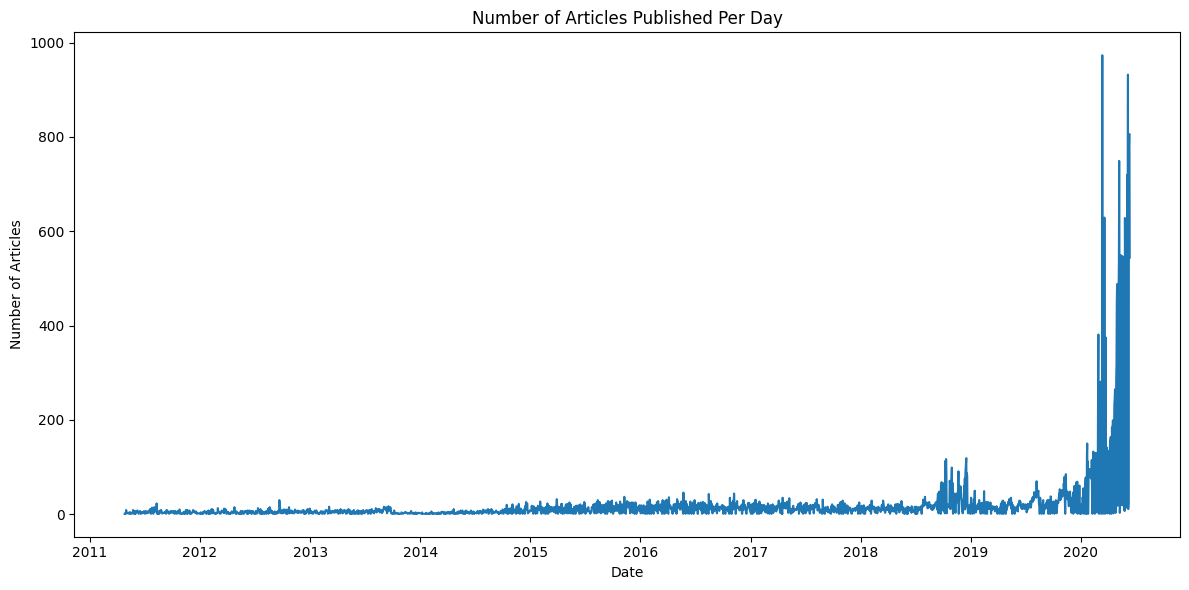

In [4]:
# Headline length
df['headline_length'] = df['headline'].str.len()
print("\nHeadline Length Stats:")
print(df['headline_length'].describe())

# Count the number of articles per publisher
publisher_counts = df['publisher'].value_counts()
print(publisher_counts)

# top 10 active publishers
print(publisher_counts.head(10))

#  Date analysis and publictaion date to see trends
df['date'] = pd.to_datetime(df['date'], errors='coerce', infer_datetime_format=True)
print("\nDate Range:", df['date'].min(), "to", df['date'].max())

articles_per_day = df.groupby(df['date'].dt.date).size()# group articles by date and count article per day
plt.figure(figsize=(12, 6))# plottig the trend over time
articles_per_day.plot()
plt.title('Number of Articles Published Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.tight_layout()
plt.show()

## Text analysis(Topic Modeling)

In [5]:
# pereprocessing the text in the 'headline' column
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize (split into words)
    tokens = text.split()
    # Remove stopwords
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS]
    return tokens

# Apply preprocessing to the 'headline' column and store as a new column
df['headline_tokens'] = df['headline'].dropna().apply(preprocess_text)

# Show a few examples
print(df[['headline', 'headline_tokens']].head())

# Create a CountVectorizer for unigrams and bigrams, removing English stopwords
headlines = df['headline'].dropna()

vectorizer = CountVectorizer(stop_words='english', ngram_range=(2,2))
X = vectorizer.fit_transform(headlines)

# Sum up the counts of each vocabulary word/phrase
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Print the top 10 keywords/phrases
print("Top 10 keywords/phrases in headlines:")
for word, freq in words_freq[:10]:
    print(f"{word}: {freq}")

                                            headline  \
0            Stocks That Hit 52-Week Highs On Friday   
1         Stocks That Hit 52-Week Highs On Wednesday   
2                      71 Biggest Movers From Friday   
3       46 Stocks Moving In Friday's Mid-Day Session   
4  B of A Securities Maintains Neutral on Agilent...   

                                     headline_tokens  
0               [stocks, hit, 52week, highs, friday]  
1            [stocks, hit, 52week, highs, wednesday]  
2                      [71, biggest, movers, friday]  
3     [46, stocks, moving, fridays, midday, session]  
4  [b, securities, maintains, neutral, agilent, t...  
Top 10 keywords/phrases in headlines:
52 week: 51006
price target: 47274
stocks moving: 40044
mid day: 37324
market update: 33101
earnings scheduled: 32055
initiates coverage: 28993
pre market: 28393
raises pt: 27213
companies trading: 23170


## Time series analysis

In [6]:
#  reseting date  to a column
if df.index.name == 'date':
    df = df.reset_index()
# Make sure 'date' is a datetime type
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# HOUR OF DAY (0-23)
df['hour'] = df['date'].dt.hour
hour_counts = df['hour'].value_counts().sort_index()
print("Articles by hour of day:\n", hour_counts)
print("Hour with highest publication:", hour_counts.idxmax())

# DAY OF WEEK (Monday-Sunday)
df['weekday'] = df['date'].dt.day_name()
weekday_counts = df['weekday'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
print("\nArticles by weekday:\n", weekday_counts)
print("Weekday with highest publication:", weekday_counts.idxmax())

# MONTH (January-December)
df['month'] = df['date'].dt.month_name()
month_counts = df['month'].value_counts().reindex(
    ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
)
print("\nArticles by month:\n", month_counts)
print("Month with highest publication:", month_counts.idxmax())

# YEAR (2011-2020)
df['year'] = df['date'].dt.year
year_counts = df['year'].value_counts().sort_index()
print("\nArticles by year:\n", year_counts)
print("Year with highest publication:", year_counts.idxmax())

# DAY (which specific date had the most articles)
day_counts = df['date'].dt.date.value_counts()
print("\nDay with highest publication:", day_counts.idxmax(), "with", day_counts.max(), "articles")

Articles by hour of day:
 hour
0.0       67
1.0       14
2.0       57
3.0       93
4.0     1469
5.0     1829
6.0     2476
7.0     5033
8.0     5527
9.0     5965
10.0    7669
11.0    5701
12.0    5732
13.0    2710
14.0    2075
15.0    1612
16.0    3939
17.0    2800
18.0     704
19.0     227
20.0     131
21.0      82
22.0      48
23.0      27
Name: count, dtype: int64
Hour with highest publication: 10.0

Articles by weekday:
 weekday
Monday       10322
Tuesday      11002
Wednesday    11891
Thursday     12688
Friday        9381
Saturday       267
Sunday         436
Name: count, dtype: int64
Weekday with highest publication: Thursday

Articles by month:
 month
January       3068
February      4091
March         6391
April         6468
May          11363
June          7968
July          2131
August        2858
September     2417
October       3079
November      3210
December      2943
Name: count, dtype: int64
Month with highest publication: May

Articles by year:
 year
2011.0      760
2012

## publisher analysis

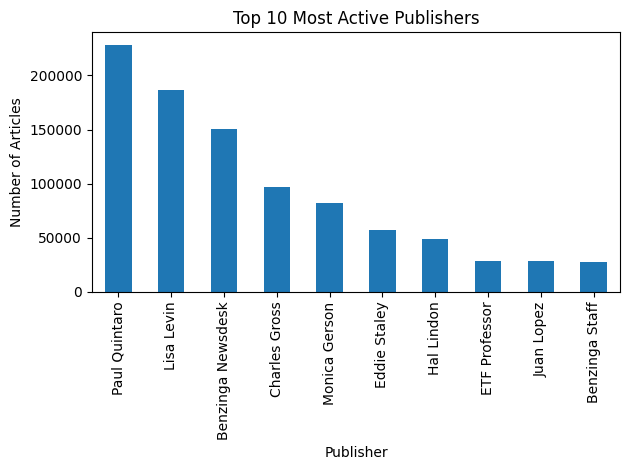


Sample headlines from Paul Quintaro:
Agilent Reports Purchase Of Genohm, No Terms Di...
UPDATE: Alnylam, Agilent Deal Has Initial Term ...
Alnylam Pharma 8-K Shows Co. Entered Manufactur...
Agilent Reports Purchase Of Luxcel Biosciences,...
Agilent Sees Q1 Adj. EPS $0.55-$0.57 vs $0.60 E...

Sample headlines from Lisa Levin:
                  71 Biggest Movers From Friday
   46 Stocks Moving In Friday's Mid-Day Session
     10 Biggest Price Target Changes For Friday
30 Stocks Moving in Friday's Pre-Market Session
            Earnings Scheduled For May 21, 2020

Sample headlines from Benzinga Newsdesk:
Agilent Technologies shares are trading higher ...
Agilent Technologies shares are trading higher ...
Agilent Technologies Q2 Adj. EPS $0.71 Beats $0...
Pershing Square 13F Shows Fund Raises Stake In ...
Shares of several healthcare companies are trad...
Top publisher domains:
publisher_domain
benzinga.com              7937
gmail.com                  139
andyswan.com                 5
in

In [7]:
#  Visualize the top 10 publishers
publisher_counts.head(10).plot(kind='bar')
plt.title('Top 10 Most Active Publishers')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.tight_layout()
plt.show()

# Show a few headlines for top publishers
top_publishers = publisher_counts.head(3).index
for pub in top_publishers:
    print(f"\nSample headlines from {pub}:")
    print(df[df['publisher'] == pub]['headline'].head(5).to_string(index=False))


# Extract domain if publisher is an email address
df['publisher_domain'] = df['publisher'].str.extract(r'@([\w\.-]+)')
domain_counts = df['publisher_domain'].value_counts()
print("Top publisher domains:")
print(domain_counts.head(10))